# Introduction

The primary objective of this project is to predict the localization labels of protein organelles for each sample in a dataset containing images obtained through confocal microscopy. The dataset encompasses 10 distinct labels representing various protein organelle localizations. It is crucial to note that the dataset includes 10 different cell types, each exhibiting highly diverse morphologies, which directly influence the protein patterns of various organelles. Images within the dataset may have one or more labels associated with them.

The overarching goal of this project is to develop a model capable of predicting, for a given image the classes determining one or more proteins. This problem is framed as a multi-label classification challenge, and the mean F1-score is selected as the evaluation metric.

In [1]:
# Loading the necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
import zipfile
import os
import keras
import cv2
import keras.backend as K

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [2]:
# Google Colab was used to run the model on a GPU
print("GPU Available: ", tensorflow.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available:  True


# Data Exploration and Processing

In this section of the report, I aim to delve into the features of the dataset. The dataset comprises images with a resolution of 128 x 128 pixels and is composed of three channels (RGB). All images are formatted in PNG.

The training set encompasses 15,389 images, while the test set includes 3,847 images. To facilitate the analysis, the data is uploaded to the temporary file directory of the Google Colab notebook as a compressed zip file. Subsequently, it is extracted and organized into the appropriate directories for further processing.

In [3]:
drive.mount('/content/drive', force_remount=True)

# Load the existed Training & Validation & Testing Dataset
base_path = '/content/drive/MyDrive/MLproject2/'

# Specify the names of your zip files
train_zip_file = 'train.zip'
test_zip_file = 'test.zip'

# Define the paths for the zip files
train_zip_file_path = os.path.join(base_path, train_zip_file)
test_zip_file_path = os.path.join(base_path, test_zip_file)

# Define the temporary extraction paths for train and test
temp_train_extract_path = '/content/train'
temp_test_extract_path = '/content/test'

# Create the temporary extraction folders if they don't exist
os.makedirs(temp_train_extract_path, exist_ok=True)
os.makedirs(temp_test_extract_path, exist_ok=True)

# Extract the contents of the train zip file into the temporary train folder
with zipfile.ZipFile(train_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(temp_train_extract_path)

# List the contents of the temporary train folder for the train zip file
print(f"Contents of {temp_train_extract_path} for {train_zip_file}: {os.listdir(temp_train_extract_path)}")

# Extract the contents of the test zip file into the temporary test folder
with zipfile.ZipFile(test_zip_file_path, 'r') as zip_ref:
    # Extract all contents directly into the test folder
    zip_ref.extractall(temp_test_extract_path)

# List the contents of the temporary test folder for the test zip file
print(f"Contents of {temp_test_extract_path} for {test_zip_file}: {os.listdir(temp_test_extract_path)}")

Mounted at /content/drive
Contents of /content/train for train.zip: ['train']
Contents of /content/test for test.zip: ['test']


The class labels associated with the images are stored in a CSV file, featuring 'Image' and 'Label' columns. Each 'Image' corresponds to the image file name, with '.png' appended for ease of loading during model training and testing. Additionally, the categorical labels, ranging from 0 to 9, are separated into distinct columns within the DataFrame. This arrangement facilitates later retrieval and transformation into one-hot encoded labels.

The label categories are defined as follows:
- 0: 'Mitochondria'
- 1: 'Nuclear bodies'
- 2: 'Nucleoli'
- 3: 'Golgi apparatus'
- 4: 'Nucleoplasm'
- 5: 'Nucleoli fibrillar center'
- 6: 'Cytosol'
- 7: 'Plasma membrane'
- 8: 'Centrosome'
- 9: 'Nuclear speckles'

The labels are read from the CSV file, and the 'Image' column is modified by appending '.png'. The 'Label' column is then transformed into a one-hot encoded format using the MultiLabelBinarizer. The resulting one-hot encoded labels are integrated into the DataFrame, and the original 'Label' column is subsequently dropped. The DataFrame columns are renamed for clarity using the specified naming convention.

In [4]:
# Load and preprocess the training data
df = pd.read_csv(f"{base_path}train.csv")
df["Image"] = df["Image"].astype(str) + ".png"
labels = df["Label"].apply(lambda x: list(map(int, x.split())))
mlb = MultiLabelBinarizer()

# Fit and transform the labels column
one_hot_encoded = mlb.fit_transform(labels).astype('float32')

# Add one-hot encoded labels to the DataFrame
df = pd.concat([df, pd.DataFrame(one_hot_encoded, columns=mlb.classes_)], axis=1)

# Drop the original "Label" column
df = df.drop("Label", axis=1)
new_column_names = {i: f"class {i}" for i in range(10)}
df = df.rename(columns=new_column_names)

In [13]:
labels_images = {
    0: '0: Mitochondria',
    1: '1: Nuclear bodies',
    2: '2: Nucleoli',
    3: '3: Golgi apparatus',
    4: '4: Nucleoplasm',
    5: '5: Nucleoli fibrillar center',
    6: '6: Cytosol',
    7: '7: Plasma membrane',
    8: '8: Centrosome',
    9: '9: Nuclear speckles'
}

The distribution of individual labels is examined using a histogram.

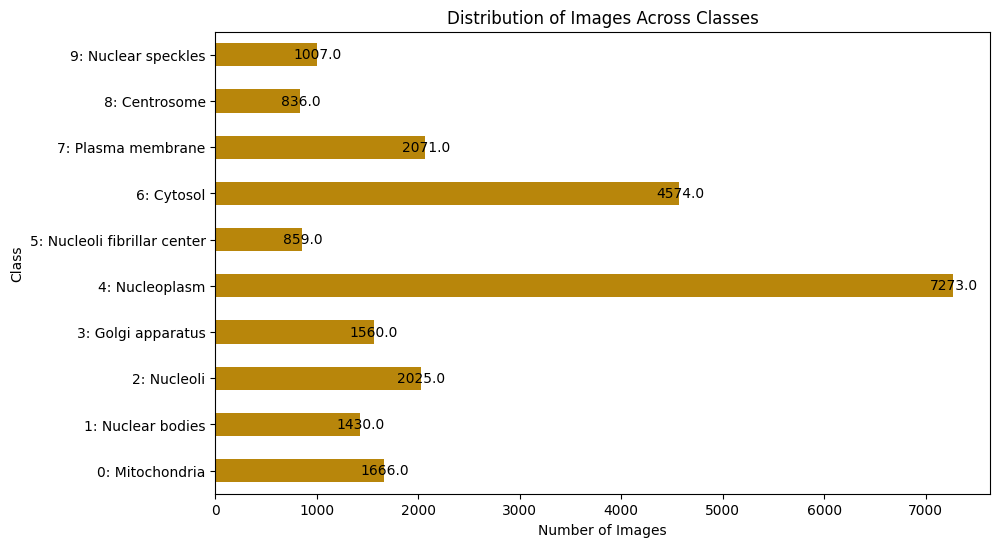

In [16]:
class_counts = df[list(new_column_names.values())].sum(axis=0)
plt.figure(figsize=(10, 6))
class_counts.plot(kind='barh', color='darkgoldenrod')
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.title('Distribution of Images Across Classes')
plt.yticks(range(10), [labels_images[int(label.split()[-1])] for label in class_counts.index])
for i, count in enumerate(class_counts.values):
    plt.text(count + 5, i, str(count), ha='center', va='center')
plt.show()

Labels 4 and 6 exhibit a significant prevalence, featuring 7273 and 4574 images, respectively. In contrast, all other labels are associated with fewer than 2000 images. Additionally, labels 8 and 5 are particularly scarce, each having fewer than 1000 images associated with them.

The class imbalance observed in the dataset poses a challenge for classification models due to its potential to introduce biases and hinder the model's ability to generalize effectively. The abundance of instances in certain labels can lead the model to prioritize those classes, potentially resulting in less accurate predictions for minority classes. This imbalance may also impact the evaluation of the model, as traditional metrics like accuracy may not adequately reflect its true performance across all classes.

To better understand the distribution of labels in this multi-label challenge, the diverse combinations and distributions of labels are analyzed. This exploration enables me to identify patterns and relationships among different classes, fostering a more thorough grasp of the inherent complexity in the data.

In [31]:
class_counts = df[list(new_column_names.values())].sum(axis=1).value_counts().sort_index()
print(class_counts)

1.0    8538
2.0    5835
3.0     971
4.0      45
dtype: int64


The distribution of the number of classes per sample in the dataset reveals that a significant portion, 8538 samples, contains only one class. Furthermore, a substantial number of samples, 5835, exhibit two classes, while a smaller proportion includes three (971) or four (45) distinct classes.

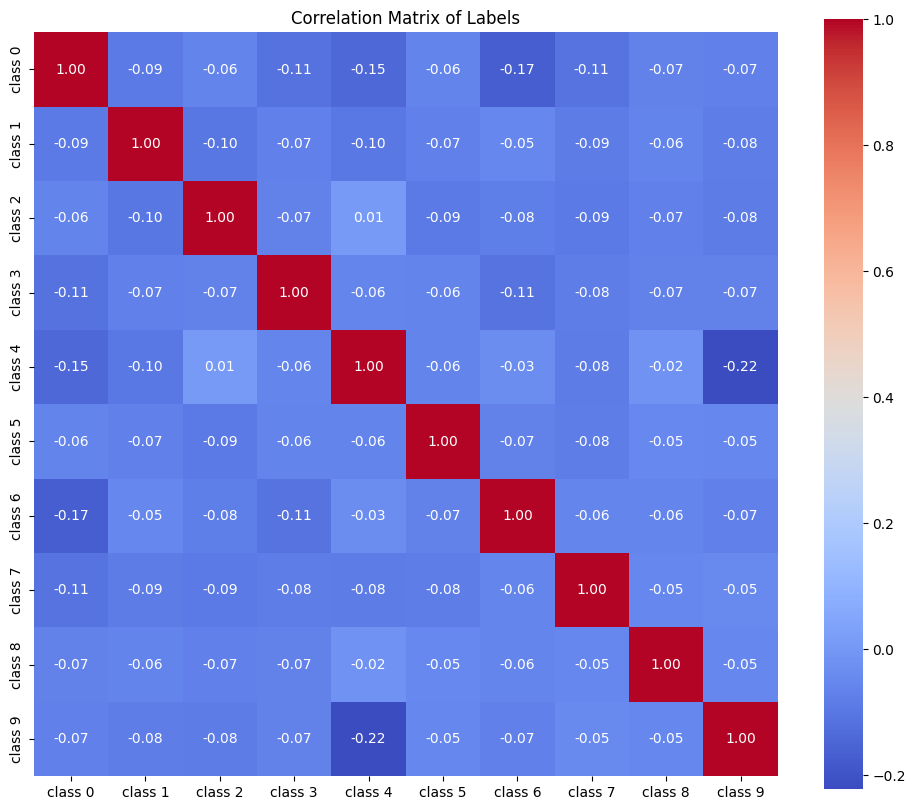

In [40]:
# Extracting columns related to labels
label_columns = df[list(new_column_names.values())]

# Creating a correlation matrix
correlation_matrix = label_columns.corr()

# Plotting a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Labels')
plt.show()

The generated correlation matrix visually depicted in the heatmap reveals that there are no prominent correlations among the different labels. The lack of distinct patterns suggests a certain degree of independence or low linear relationships between the various classes, highlighting the diverse and complex nature of the multi-label classification problem.

In [42]:
# Counting occurrences of each label combination
label_columns = df[list(new_column_names.values())]
label_combinations_counts = label_columns.groupby(list(new_column_names.values())).size().reset_index(name='Count')

# Sorting the DataFrame based on 'Count' in descending order
label_combinations_counts = label_combinations_counts.sort_values(by='Count', ascending=False)
label_combinations_counts = label_combinations_counts.reset_index(drop=True)
label_combinations_counts

,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9,Count
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2218
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1401
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1272
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,973
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,761
...,...,...,...,...,...,...,...,...,...,...,...
117,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1
118,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1
119,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1
120,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1


<Figure size 1500x800 with 0 Axes>

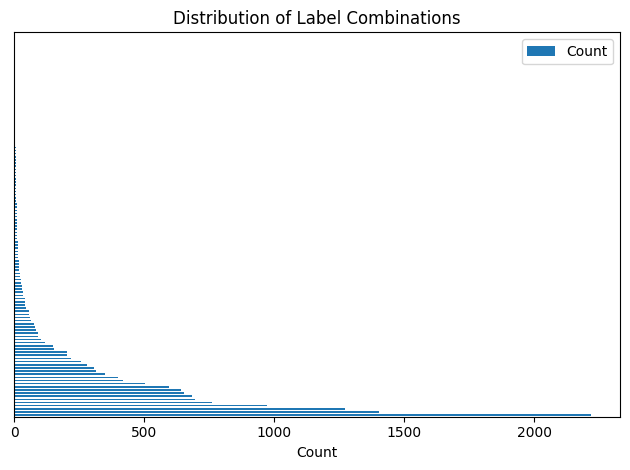

In [55]:
# Sorting the DataFrame based on 'Count' in descending order
label_combinations_counts = label_combinations_counts.sort_values(by='Count', ascending=False)
label_combinations_counts = label_combinations_counts.reset_index(drop=True)

# Plotting a bar chart using Pandas plotting
plt.figure(figsize=(15, 8))
ax = label_combinations_counts.set_index(label_combinations_counts.columns[:-1].astype(str).tolist()).plot(kind='barh', stacked=True)
ax.get_yaxis().set_visible(False)  # Remove y-axis ticks
plt.xlabel('Count')
plt.ylabel('Label Combination')
plt.title('Distribution of Label Combinations')
plt.tight_layout()
plt.show()

The distribution of distinct label combinations bears a resemblance to a Poisson distribution, with numerous combinations occurring only once. Some combinations are very abundant, for instance, out of the 122 unique label combinations, 2218 instances exclusively feature class 4, 1401 instances showcase a combination of both class 4 and class 6, and 1272 instances solely incorporate class 6. This observed pattern underscores the dataset's diversity and sparse distribution of label combinations, where a significant number occur infrequently. Considering the Poisson-like nature of the distribution, transforming the multi-label problem into a multi-class problem by treating each unique combination as a separate label might not be advisable. The abundance of sparse unique combinations poses challenges for the model to effectively learn from such instances.

Using class weights is a beneficial strategy to counteract the challenges posed by class imbalance in classification models. By assigning higher weights to less-represented classes, this technique ensures that the model places increased emphasis on learning from minority class instances. This adjustment helps prevent biases that may arise due to the dominance of majority classes, fostering more accurate predictions for the underrepresented ones. The incorporation of class weights contributes to improved model generalization, enhancing its ability to make precise predictions across diverse classes in real-world scenarios. Moreover, the simplicity of implementing class weights makes them a practical and effective solution, compatible with various classification models.

In [17]:
total_samples = len(df)
total_samples = class_counts.sum()
class_weights = {class_idx: total_samples / count for class_idx, count in enumerate(class_counts)}
print(class_weights)

{0: 13.986194477791116, 1: 16.294405594405596, 2: 11.506666666666666, 3: 14.936538461538461, 4: 3.203767358724048, 5: 27.12572759022119, 6: 5.094228246611281, 7: 11.25108643167552, 8: 27.87200956937799, 9: 23.139026812313805}


Data augmentation, exemplified by thd custom preprocessing function and specified augmentations in the code below, enhances the diversity of the training dataset. This technique introduces variations like rotations and flips, enabling the model to learn more robust features, adapt to real-world conditions, and reduce sensitivity to image variability. The approach is particularly useful for tackling imbalanced datasets, as it creates augmented versions of minority class instances, fostering better model performance across diverse classes.

In [18]:
def custom_preprocessing(image):
    # Normalize image using InceptionResNetV2 preprocess_input
    image = preprocess_input(image)
    return image

# Create an image data generator with augmentation
datagen_train = ImageDataGenerator(preprocessing_function=custom_preprocessing,
                                  rotation_range=180,
                                  fill_mode='reflect',
                                  horizontal_flip=True,
                                  vertical_flip=True)

datagen_valtest = ImageDataGenerator(preprocessing_function=custom_preprocessing,
                                  rotation_range=180,
                                  fill_mode='reflect',
                                  horizontal_flip=True,
                                  vertical_flip=True)


The data is split into a training and validation dataset.

In [ ]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
train_df.head()

,Image,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
8018,22777.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5873,16001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14995,17137.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3295,25617.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
177,19360.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
val_df.head()

,Image,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,class 9
3708,4718.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3402,30457.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10826,8195.png,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
11528,17351.png,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9960,15246.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Let's examine an individual image within the dataset. This particular image is a low-resolution (128x128) RGB PNG image, annotated with both class 4 (Nucleoplasm) and class 7 (Plasma Membrane).

In [ ]:
image_path = 'train/train/21632.png'
image = cv2.imread(image_path)

# Check the shape of the image array
image_shape = image.shape

# Extract the number of channels from the shape
num_channels = image_shape[-1]
print(f"The image has {num_channels} channels.")

The image has 3 channels.


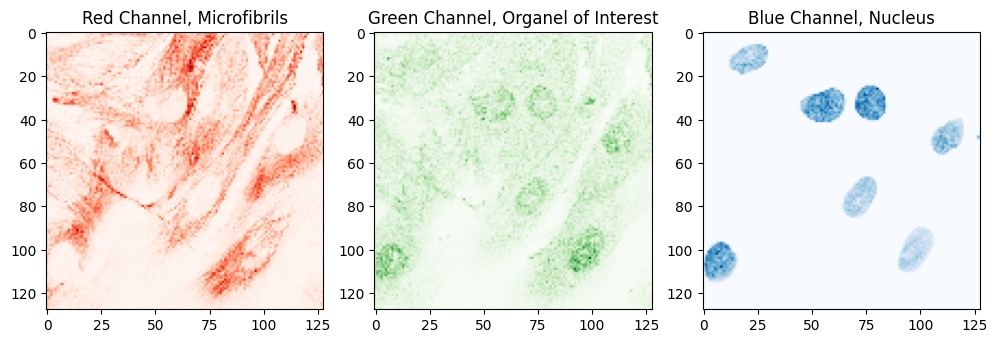

In [ ]:
# Split the image into RGB channels
blue_channel = image[:, :, 0]
green_channel = image[:, :, 1]
red_channel = image[:, :, 2]

# Display the original image and its RGB channels
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel, Microfibrils')

plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel, Organel of Interest')

plt.subplot(1, 3, 3)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel, Nucleus')

plt.tight_layout()
plt.show()

The primary objective of this project is to develop a robust model capable of predicting the classes determining one or more proteins within a given image. Given the absence of a standardized coordinate system, protein localization is inferred by its spatial relationship to the nucleus (in the blue channel) and microtubules (in the red channel), with the protein of interest consistently appearing in the green channel.

To enhance the precision of localization, each layer serves as a distinctive landmark. The blue channel, representing nuclei, significantly narrows down potential localizations. When the green channel exclusively overlaps with the blue, it indicates a nuclear localization. Moving into the cytosol, the red channel portrays microtubules, aiding in further classification based on cellular scaffolding and organelle distribution. The learning process involves distinguishing between nuclear and cytosolic presence, potential nuclear edge positioning, and specific cytosolic localizations within organelles or protein complexes. This approach ensures a nuanced understanding of protein distribution patterns for accurate predictions.

Convolutional Neural Networks (CNNs) are particularly well-suited for this task due to their inherent ability to capture hierarchical spatial features. CNNs excel in recognizing patterns and relationships within images, making them apt for discerning intricate cellular structures and protein localizations. Their capacity to automatically learn hierarchical representations allows the model to grasp complex dependencies in the data, facilitating accurate predictions based on the distinct patterns present in different channels. The utilization of CNNs enhances the model's capability to discern nuanced spatial features, making it a robust choice for the intricate task of protein localization prediction.

# Model Building

Due to imbalances in both individual labels and label combinations, the limited size of the training dataset (approximately 14,000 images), and the intricate nature of protein localization, a pretrained model is employed. Specifically, the InceptionResNetV2 model, pretrained on ImageNet, is utilized. The initial classification layer is omitted, and a custom 'head' is appended, consisting of two additional layers. The final layer incorporates a sigmoid activation function, producing probabilities for each label. This choice aligns with the principles of transfer learning, allowing the model to leverage knowledge gained from a large-scale dataset for improved generalization. InceptionResNetV2's architectural design makes it resilient to variations in input images, making it suitable for the diverse and complex nature of cellular images.

I opted for InceptionResNetV2 for this task due to its powerful feature extraction capabilities and proven effectiveness in discerning intricate patterns in images. This architecture combines the strengths of Inception and ResNet, providing a robust framework for capturing detailed hierarchical features, which is crucial for the complex nature of protein localization. The fact that InceptionResNetV2 has been pretrained on ImageNet is a major advantage, as it brings a broad understanding of visual features to the model, facilitating better performance with our limited training dataset of around 14000 images.

Inception, known for its inception modules, excels in extracting features at various spatial scales simultaneously. This allows the network to capture both fine and coarse details in the images, essential for discerning complex protein localization patterns.

The incorporation of residual connections from the ResNet architecture enhances the model's ability to tackle the challenges of training deep networks. Residual connections facilitate the smooth flow of gradients during backpropagation, mitigating issues like vanishing gradients. This is particularly advantageous when dealing with deep architectures, ensuring effective learning and feature representation.

In [ ]:
# Load InceptionResNetV2 without top (classification head)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, pooling="avg", input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model by adding your custom layers on top of InceptionResNetV2
model = Sequential([
    base_model,
    Dense(512, activation="relu"),
    Dense(10, activation="sigmoid")  # Sigmoid activation for multi-label)
])

219055592/219055592 [==============================] - 10s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 56440554 (215.30 MB)
Trainable params: 2103818 (8.03 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In this code segment, I've implemented several strategies to ensure the effectiveness and adaptability of our model for the protein localization task. By employing separate data generators for training and validation, real-time data augmentation is facilitated. This process introduces diversity into the training set, enabling the model to generalize better to unseen variations in protein localization patterns.

Connecting dataframes with image files through flow_from_dataframe streamlines the data input pipeline, ensuring seamless integration between the dataset information and the actual images. This organized approach enhances the efficiency of model training and validation.

The introduction of a custom F1 loss function acknowledges the intricacies of multi-label classification. This tailored loss metric considers true positives, false positives, and false negatives, providing a nuanced evaluation of our model's performance, especially crucial when dealing with imbalanced datasets.

As for model compilation, the choice of the Adam optimizer and the inclusion of metrics like recall and precision offer a comprehensive assessment of the model's capabilities beyond the primary loss function.

Moreover, the integration of a learning rate scheduler with ReduceLROnPlateau optimally adjusts the learning rate during training. This adaptive mechanism helps fine-tune the model's convergence, ensuring optimal performance and responsiveness to evolving training dynamics.

In [ ]:
# Create separate data generators for training and validation
train_generator = datagen_train.flow_from_dataframe(dataframe=train_df, directory="/content/train/train/", x_col="Image",
                                              y_col=list(new_column_names.values()), class_mode="other",
                                              target_size=(128, 128), batch_size=512, shuffle=True)

validation_generator = datagen_valtest.flow_from_dataframe(dataframe=val_df, directory="/content/train/train/", x_col="Image",
                                            y_col=list(new_column_names.values()), class_mode="other",
                                            target_size=(128, 128), batch_size=512, shuffle=False)

# Loss function
def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tensorflow.where(tensorflow.math.is_nan(f1), tensorflow.zeros_like(f1), f1)
    return 1 - K.mean(f1)


# Compile the model
adam_optimizer = Adam(learning_rate=0.0001, amsgrad=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
model.compile(optimizer=adam_optimizer, loss=f1_loss,
              metrics=[tensorflow.keras.metrics.Recall(), tensorflow.keras.metrics.Precision()])

#model.load_weights('model_weights.h5')

Found 13850 validated image filenames.
Found 1539 validated image filenames.


This visual exploration provides a snapshot of the dataset, aiding in understanding the variety and complexity of protein localizations present. It also serves as a valuable tool for validating the preprocessing steps and ensuring that the model is being fed meaningful and representative input during the training process.

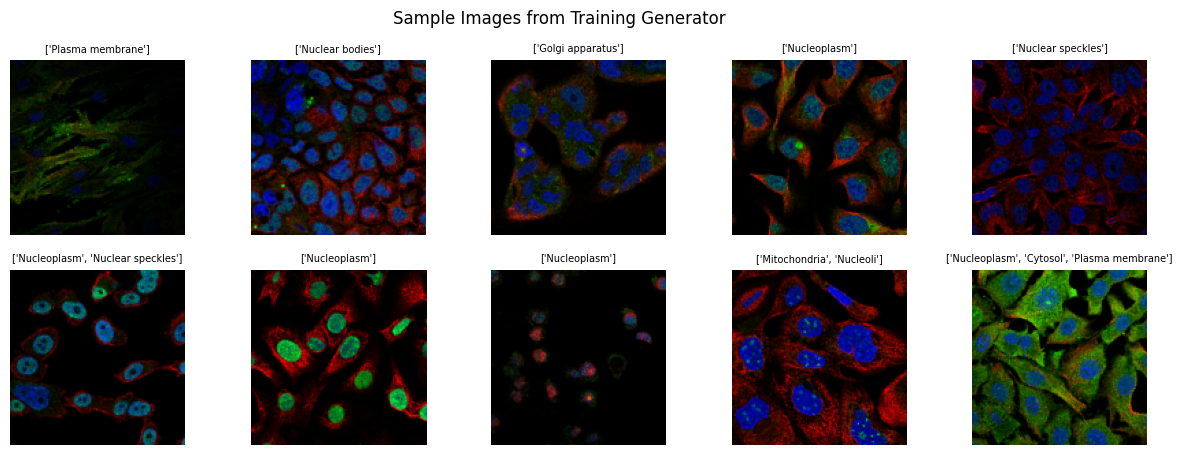

In [ ]:
# Number of images to display
num_images = 10

# Get a batch of images and labels from the training generator
images, numerical_labels = train_generator.next()

# Custom normalization function to reverse scaling to [-1, 1]
def reverse_scaling(image):
    return (image + 1.0) / 2.0

# Display the images in a grid
plt.figure(figsize=(15, 5))
for i in range(num_images):
    classes = list(numerical_labels[i])
    class_names = [labels_images[i] for i, value in enumerate(classes) if value == 1]

    # Reverse ResNet scaling
    normalized_image = reverse_scaling(images[i])

    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(normalized_image)
    plt.title(f'{class_names}', fontsize=7)  # Include image name in title
    plt.axis('off')

plt.suptitle('Sample Images from Training Generator', fontsize=12)  # Adjust font size here
plt.show()

# Training and Validation

The model was trained in steps of 10 epochs, for which the output of epoch 40 to 50 can be seen below.

In [ ]:
tensorflow.keras.backend.clear_session()
num_epochs = 10
history = model.fit(train_generator, epochs=num_epochs, validation_data = validation_generator, callbacks=[reduce_lr])

Epoch 1/10
28/28 [==============================] - 96s 3s/step - loss: 0.6867 - recall: 0.6937 - precision: 0.2997 - val_loss: 0.6982 - val_recall: 0.6844 - val_precision: 0.2996 - lr: 6.2500e-06
Epoch 2/10
28/28 [==============================] - 91s 3s/step - loss: 0.6895 - recall: 0.6881 - precision: 0.3020 - val_loss: 0.6970 - val_recall: 0.6814 - val_precision: 0.2972 - lr: 6.2500e-06
Epoch 3/10
28/28 [==============================] - 86s 3s/step - loss: 0.6858 - recall: 0.6913 - precision: 0.3013 - val_loss: 0.6973 - val_recall: 0.6853 - val_precision: 0.2960 - lr: 6.2500e-06
Epoch 4/10
28/28 [==============================] - ETA: 0s - loss: 0.6866 - recall: 0.6987 - precision: 0.2970
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
28/28 [==============================] - 89s 3s/step - loss: 0.6866 - recall: 0.6987 - precision: 0.2970 - val_loss: 0.6973 - val_recall: 0.6917 - val_precision: 0.2932 - lr: 6.2500e-06
Epoch 5/10
28/28 [==================

The learning rate scheduler adjust the learning rate as follows:

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 24: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 34: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 39: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 46: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 48: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 50: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

After 50 epochs, the learning rate has reached its minimum, exhibiting no improvement in either the training or validation loss. The additional layers added to the pre-trained model have undergone training to convergence on the training data.

In the subsequent stage, the base model is 'unfrozen,' and the entire model is retrained with a significantly reduced learning rate.

It is imperative to execute this step only after the model with frozen layers has achieved convergence. If randomly-initialized trainable layers are combined with trainable layers holding pre-trained features, the former can induce substantial gradient updates during training, potentially compromising the pre-trained features.

Moreover, it is crucial to employ an exceptionally low learning rate at this point. The model being trained is substantially larger than in the initial training phase, and the dataset is relatively small. Consequently, there is a heightened risk of quick overfitting if substantial weight updates are applied. The objective here is to incrementally readapt the pretrained weights. To further achieve this, only 1 epochs is utilized to evaluate the model based on metrics and density plots of predictions on the validation dataset.

In [ ]:
base_model.trainable = True

# Compile the model
adam_optimizer = Adam(learning_rate=0.000001, amsgrad=True)
model.compile(optimizer=adam_optimizer, loss=f1_loss,
              metrics=[tensorflow.keras.metrics.Recall(), tensorflow.keras.metrics.Precision()])

# Finetuning the model
num_epochs = 1
history = model.fit(train_generator, epochs=num_epochs, validation_data = validation_generator, callbacks=[reduce_lr])

Nevertheless, when executing this code, an error surfaces—namely, a ResourceExhaustedError. This error commonly signifies that the GPU memory is inadequate to accommodate the tensors required during training. The specific error message points to an "OOM when allocating tensor with shape[512,1088,6,6] and type float." This implies that a layer in the Inception ResNet V2 model is producing a tensor too large to fit within the available GPU memory.

To address this issue, the error was mitigated by reducing the batch sizes from 512 to 128. However, this adjustment introduces a potential drawback: a compromised accuracy in the macro F1 score. Given that the macro F1 score serves as the loss function, this compromise can pose a potential problem as a batch of 128 is less likely to be representative of the entire training set than a batch of 512.

In [ ]:
# Adjust batch size to 128
train_generator = datagen_train.flow_from_dataframe(dataframe=train_df, directory="/content/train/train/", x_col="Image",
                                              y_col=list(new_column_names.values()), class_mode="other",
                                              target_size=(128, 128), batch_size=128, shuffle=True)

validation_generator = datagen_valtest.flow_from_dataframe(dataframe=val_df, directory="/content/train/train/", x_col="Image",
                                            y_col=list(new_column_names.values()), class_mode="other",
                                            target_size=(128, 128), batch_size=128, shuffle=False)

# Compile the model
adam_optimizer = Adam(learning_rate=0.000001, amsgrad=True)
model.compile(optimizer=adam_optimizer, loss=f1_loss,
              metrics=[tensorflow.keras.metrics.Recall(), tensorflow.keras.metrics.Precision()])

Found 13850 validated image filenames.
Found 1539 validated image filenames.


In [ ]:
# Finetuning the model
num_epochs = 1
history = model.fit(train_generator, epochs=num_epochs, validation_data = validation_generator, callbacks=[reduce_lr])

109/109 [==============================] - 237s 1s/step - loss: 0.7687 - recall_1: 0.5853 - precision_1: 0.3222 - val_loss: 0.7550 - val_recall_1: 0.6410 - val_precision_1: 0.2900 - lr: 1.0000e-06


Following a single epoch, the loss has shown an unexpected increase rather than the anticipated decrease. To address this divergence, the model is subjected to additional finetuning for an additional 5 epochs, with the expectation that this refinement stage will contribute to the reduction of losses.

In [ ]:
# Finetuning the model for 5 more epoch
num_epochs = 5
history = model.fit(train_generator, epochs=num_epochs, validation_data = validation_generator, callbacks=[reduce_lr])

Epoch 1/5
109/109 [==============================] - 120s 1s/step - loss: 0.7595 - recall_1: 0.6072 - precision_1: 0.3070 - val_loss: 0.7516 - val_recall_1: 0.6401 - val_precision_1: 0.2862 - lr: 1.0000e-06
Epoch 2/5
109/109 [==============================] - 109s 1000ms/step - loss: 0.7526 - recall_1: 0.6324 - precision_1: 0.2928 - val_loss: 0.7470 - val_recall_1: 0.6482 - val_precision_1: 0.2828 - lr: 1.0000e-06
Epoch 3/5
109/109 [==============================] - 112s 1s/step - loss: 0.7479 - recall_1: 0.6530 - precision_1: 0.2807 - val_loss: 0.7449 - val_recall_1: 0.6601 - val_precision_1: 0.2739 - lr: 1.0000e-06
Epoch 4/5
109/109 [==============================] - 111s 1s/step - loss: 0.7450 - recall_1: 0.6727 - precision_1: 0.2695 - val_loss: 0.7423 - val_recall_1: 0.6738 - val_precision_1: 0.2650 - lr: 1.0000e-06
Epoch 5/5
109/109 [==============================] - 134s 1s/step - loss: 0.7397 - recall_1: 0.6964 - precision_1: 0.2646 - val_loss: 0.7399 - val_recall_1: 0.6878 - va

The losses seems to be decreasing steadily, lets finetune for 10 more epoch.

In [ ]:
# Finetuning the model for 10 more epoch
num_epochs = 10
history = model.fit(train_generator, epochs=num_epochs, validation_data = validation_generator, callbacks=[reduce_lr])

Epoch 1/10
109/109 [==============================] - 114s 1s/step - loss: 0.7373 - recall_1: 0.7049 - precision_1: 0.2587 - val_loss: 0.7377 - val_recall_1: 0.7014 - val_precision_1: 0.2576 - lr: 1.0000e-06
Epoch 2/10
109/109 [==============================] - 107s 983ms/step - loss: 0.7342 - recall_1: 0.7149 - precision_1: 0.2573 - val_loss: 0.7354 - val_recall_1: 0.7100 - val_precision_1: 0.2568 - lr: 1.0000e-06
Epoch 3/10
109/109 [==============================] - 122s 1s/step - loss: 0.7326 - recall_1: 0.7206 - precision_1: 0.2544 - val_loss: 0.7332 - val_recall_1: 0.7181 - val_precision_1: 0.2534 - lr: 1.0000e-06
Epoch 4/10
109/109 [==============================] - 112s 1s/step - loss: 0.7298 - recall_1: 0.7298 - precision_1: 0.2528 - val_loss: 0.7313 - val_recall_1: 0.7240 - val_precision_1: 0.2515 - lr: 1.0000e-06
Epoch 5/10
109/109 [==============================] - 123s 1s/step - loss: 0.7286 - recall_1: 0.7296 - precision_1: 0.2517 - val_loss: 0.7292 - val_recall_1: 0.7270 

Despite a slight additional decrease in losses, the final reduction is minimal, leading to the conclusion that continuing the model training is not justified. Additionally, the finetuning step exhibits an increase in losses compared to the pre-finetuning stage, making this step rather counter-productive.

In [ ]:
# Save the weights to a file
model.save_weights('model_weights.h5')

##Evaluating the model based on the training and validation metrics

The model underwent performance evaluation at intervals of 10 epochs. An effective method for assessing its capabilities is through a classification report, which provides detailed metrics such as precision, recall, and F1 score for each class. The report also includes various averages, we focus on the macro average F1 score as this is the score used on Kaggle. The following presents the classification report for the final model.

In [ ]:
# Get predictions
predictions_hard_cutoff = (predictions > 0.5).astype("int32")

# Get true labels
true_labels = val_df[list(new_column_names.values())].values

# Print classification report
print("Classification Report with a hard threshold of 0.5 for each class:")
print(classification_report(true_labels, predictions_hard_cutoff, target_names=list(new_column_names.values())))

Classification Report with a hard threshold of 0.5 for each class:
              precision    recall  f1-score   support

     class 0       0.14      0.69      0.23       159
     class 1       0.15      0.64      0.24       152
     class 2       0.19      0.60      0.29       224
     class 3       0.10      0.53      0.17       142
     class 4       0.47      1.00      0.64       723
     class 5       0.10      0.36      0.15        81
     class 6       0.39      0.78      0.52       464
     class 7       0.27      0.62      0.38       221
     class 8       0.07      0.38      0.12        81
     class 9       0.11      0.28      0.16       101

   micro avg       0.25      0.74      0.38      2348
   macro avg       0.20      0.59      0.29      2348
weighted avg       0.30      0.74      0.42      2348
 samples avg       0.28      0.74      0.38      2348



The training and validation metrics were visualized at 10-epoch intervals, offering valuable insights into the model's progression. The plots provide a clear depiction of decreasing losses, accompanied by fluctuations in recall and precision, ultimately influencing the F1 score positively.

In [ ]:
# Extract the training history
train_loss = history.history['loss']
train_recall = history.history['recall_1']
train_precision = history.history['precision_1']
train_f1 = [2 * (p * r) / (p + r) if p + r != 0 else 0.0 for p, r in zip(train_precision, train_recall)]
val_loss = history.history['val_loss']
val_recall = history.history['val_recall_1']
val_precision = history.history['val_precision_1']
val_f1 = [2 * (p * r) / (p + r) if p + r != 0 else 0.0 for p, r in zip(val_precision, val_recall)]

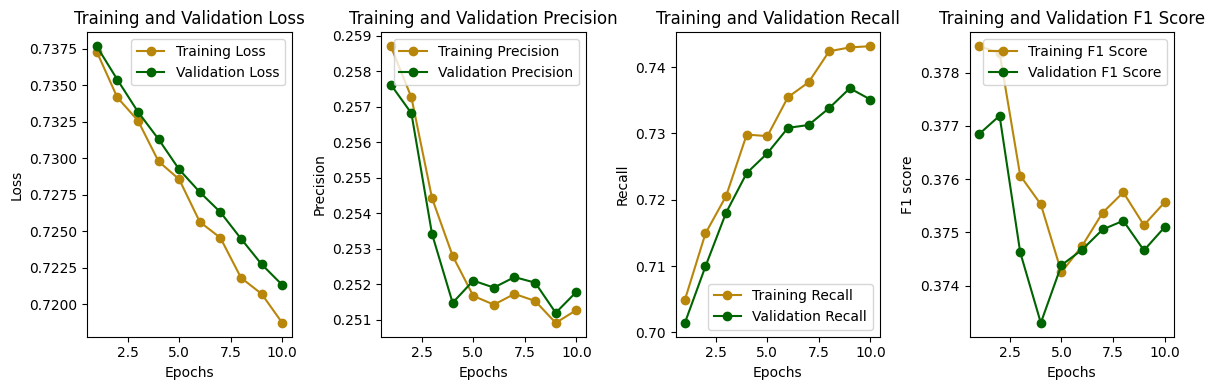

In [ ]:
# Plot the metrics
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 4, 1)
plt.plot(epochs, train_loss, 'o-', color='darkgoldenrod', label='Training Loss')
plt.plot(epochs, val_loss, 'o-', color='darkgreen', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation precision
plt.subplot(1, 4, 2)
plt.plot(epochs, train_precision, 'o-', color='darkgoldenrod', label='Training Precision')
plt.plot(epochs, val_precision, 'o-', color='darkgreen', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot training and validation recall
plt.subplot(1, 4, 3)
plt.plot(epochs, train_recall, 'o-', color='darkgoldenrod', label='Training Recall')
plt.plot(epochs, val_recall, 'o-', color='darkgreen', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plot training and validation F1 score
plt.subplot(1, 4, 4)
plt.plot(epochs, train_f1, 'o-', color='darkgoldenrod', label='Training F1 Score')
plt.plot(epochs, val_f1, 'o-', color='darkgreen', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()

plt.tight_layout()
plt.show()

Given that the primary metric for this project is the mean F1-score, it is crucial to consider both recall and precision. In the calculation of the mean F1-score, both recall and precision for all classes are given equal importance. Therefore, the presence of low precision, even in the presence of high recall, will exert a notable impact on the final F1-score. Combine this with the fact that every class gets equal weights, the prediction for each class is equally important. As the model struggles to detect the less abundant classes, this further takes down the F1 score. The F1-score serves as a balanced measure, taking into account both false positives and false negatives, making it particularly valuable in scenarios where achieving a harmonious trade-off between precision and recall is essential.

On top of this, there is no clear signs of overfitting, this can be due to the augmentation, where images are flipped, turned around and zoomed to make sure none of the training images are the same and the complex model can't 'remember' the training images because they are different every time. This ofcourse comes with a struggle as well because the model might not be able to find the right patterns if the augmentation is too harsh.

## Evaluating the model performance based on the predictions on the validation dataset

One way to generate predictions of the model is using Test Time Augmentation. Test Time Augmentation is to perform random modifications to the test images. Instead of presenting the trained model with the standard, unaltered images only once, we repeatedly expose it to augmented images. Subsequently, we average the predictions for each corresponding image, considering the augmented variations, to derive our final prediction.

In [ ]:
tta_steps = 7
predictions = []

for i in range(tta_steps):
    preds = model.predict(validation_generator)
    predictions.append(preds)

predictions = np.mean(predictions, axis=0)

true_labels = val_df[list(new_column_names.values())].values
true_labels

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'True Labels': true_labels.flatten(),
    'Predictions': predictions.flatten(),
    'Class': np.tile(np.arange(10), len(true_labels)) % 10,})

13/13 [==============================] - 3s 202ms/step


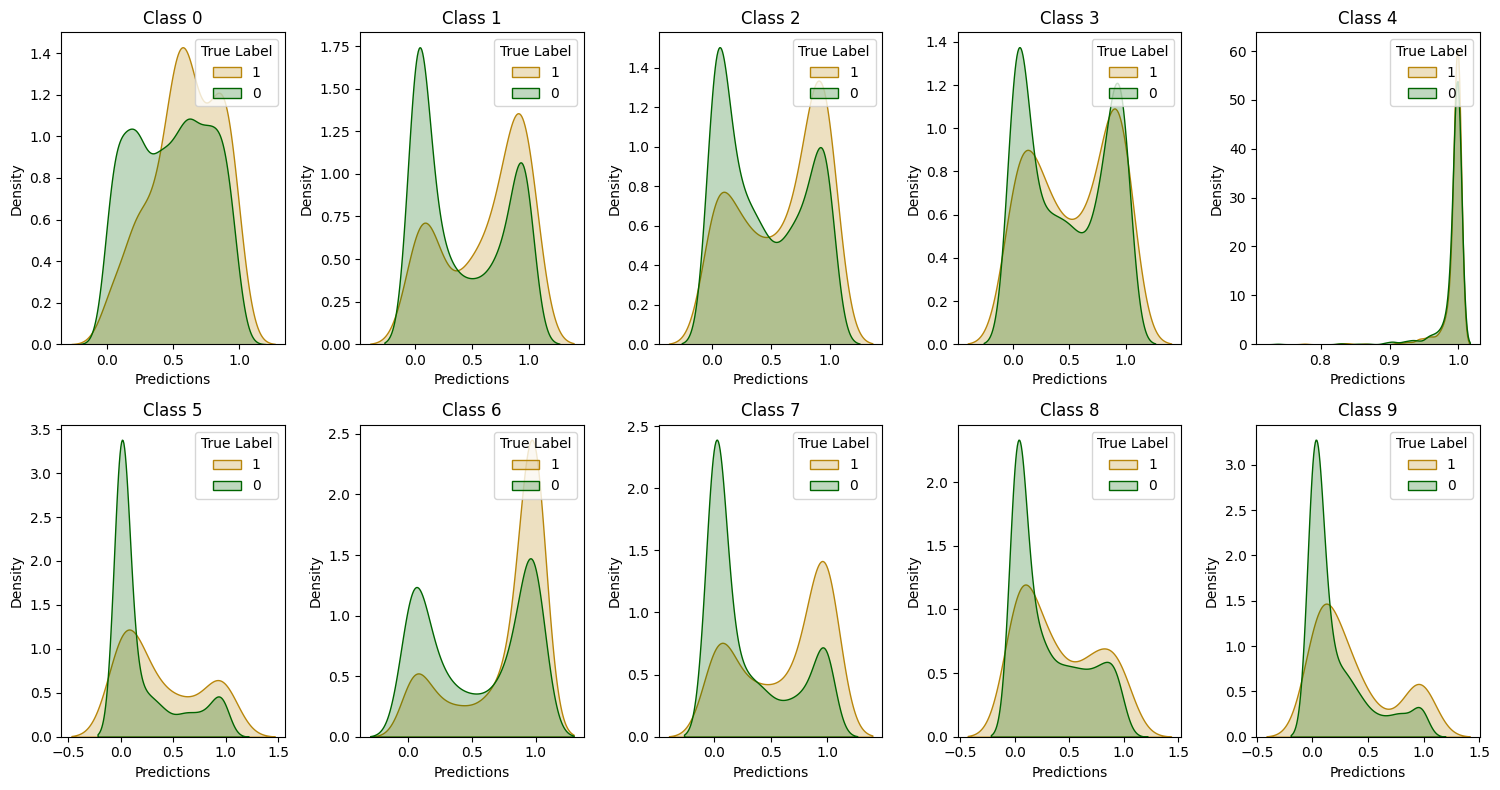

In [ ]:
# Plot density plots for each class
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(
        data=df[df['Class'] == i],
        x='Predictions',
        hue='True Labels',
        common_norm=False,
        fill=True,
        palette={0: 'darkgreen', 1: 'darkgoldenrod'})
    plt.title(f'Class {i}')
    plt.legend(title='True Label', labels=['1', '0'])

plt.tight_layout()
plt.show()

The density plots presented above serve as a valuable tool for evaluating the calibration of the model. In machine learning, calibration refers to the agreement between predicted probabilities and the actual likelihood of events occurring. Specifically, in a classification model, it involves scrutinizing how well the predicted probabilities align with the true outcomes.

When interpreting these density plots, considering the spread of predicted probabilities for each class is important. A well-calibrated model should exhibit predictions distributed across the entire range for both positive and negative cases. If the predicted probabilities are concentrated in a specific range, it may indicate calibration issues. While the overall predictions span from 0 to 1, a notable observation is the density plot for class 4, revealing that all predictions are labeled as 1, even when the true label is 0.

Additionally, analyzing the overlap between the density plots of true positive and true negative cases for each class is crucial. Ideally, there should be a distinct separation between the distributions of predicted probabilities for positive and negative cases. However, in this case, the green and yellow distributions overlap extensively across all classes.

Finally, whether the predicted probabilities align with the actual outcomes can also be assesed through these plots. For instance, if the model predicts a high probability for a positive case, it should indeed be a positive case. In our context, this alignment should manifest as a yellow peak on the right, indicating that true label 1 is being predicted as 1, while a green peak should be observed on the left, signifying that true label 0 is being predicted as 0.

The observed density plots and analyses reveal that our model lacks optimal calibration. Calibration issues are evident, particularly in the density plot for class 4, where all predictions consistently gravitate toward label 1, irrespective of the true label being 0. This concentration of predicted probabilities in specific ranges for different classes implies a deviation from the desired spread across the entire probability spectrum. Additionally, the extensive overlap between the density plots of true positive and true negative cases across various classes indicates a lack of clear distinction between the distributions for positive and negative predictions. These observations collectively point to a suboptimal alignment between predicted probabilities and the actual likelihood of events occurring, underscoring the need for recalibration efforts.

# Generating Predictions for the Test Set

One way to generate predictions for the test set is using Test Time Augmentation. Test Time Augmentation is to perform random modifications to the test images. Instead of presenting the trained model with the standard, unaltered images only once, we repeatedly expose it to augmented images. Subsequently, we average the predictions for each corresponding image, considering the augmented variations, to derive our final prediction.

In [ ]:
# Generate predictions for the test set
test_df = pd.read_csv(f"{base_path}submission.csv")
test_df["Image"] = test_df["Image"].astype(str) + ".png"
test_generator = datagen_valtest.flow_from_dataframe(dataframe=test_df, directory="/content/test/test/", x_col="Image",
                                             class_mode=None, target_size=(128, 128), batch_size=128)

Found 3847 validated image filenames.


In [ ]:
tta_steps = 7
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_generator)
    predictions.append(preds)

predictions_test = np.mean(predictions, axis=0)

31/31 [==============================] - 6s 198ms/step


These average predictions can now be used to make the final predictions that can be uploaded to Kaggle. The final submission has a macro F1 score of 0.20896 on the public leaderboard.

In [ ]:
# Format predictions and save to submission file
predictions_cutoff = (predictions_test > 0.5).astype("int32")
pred_labels = mlb.inverse_transform(predictions_cutoff)
print(pred_labels)

# Remove '.png' from the 'Image' column
test_df['Image'] = test_df['Image'].str.replace('.png', '')
submission_df = pd.DataFrame({'Image': test_df['Image'], 'Label': [' '.join(map(str, labels)) for labels in pred_labels]})
submission_df.to_csv("submission.csv", index=False)

[(0, 4, 6), (1, 2, 3, 4), (1, 2, 3, 4), (1, 4, 6), (1, 2, 4, 6, 9), (4, 6, 7), (0, 4, 6, 7), (0, 4, 6), (0, 2, 3, 4, 6), (4, 6, 7), (4, 6), (4, 6), (0, 4, 6), (0, 4, 6), (0, 2, 3, 4, 6), (1, 2, 4, 6), (4, 6), (0, 4, 6), (4, 6), (0, 2, 4, 6), (4, 6, 7), (0, 4, 6), (0, 4, 6), (2, 3, 4, 6), (4, 6, 7), (0, 3, 4, 6), (0, 1, 2, 3, 4), (0, 4, 6), (0, 1, 2, 3, 4, 6), (0, 4, 6, 7), (0, 1, 2, 3, 4, 6), (0, 3, 4, 6), (4, 6, 7), (0, 1, 2, 3, 4), (1, 4, 6), (0, 1, 2, 3, 4, 5, 8), (4, 6, 7), (2, 4, 6), (0, 4, 6), (0, 1, 2, 3, 4), (4, 6, 7), (4, 6), (4, 6), (0, 1, 2, 3, 4, 8), (4, 6, 7), (0, 4, 6), (0, 1, 3, 4), (0, 4, 6), (4, 6), (2, 3, 4, 6), (1, 2, 3, 4, 5), (0, 1, 2, 4, 6), (1, 2, 3, 4), (0, 1, 2, 3, 4), (4, 6), (0, 1, 2, 3, 4), (0, 1, 3, 4, 6), (0, 4, 6), (0, 3, 4, 6), (0, 1, 2, 3, 4, 8), (1, 2, 3, 4, 5), (0, 4, 6), (1, 2, 4, 6, 9), (4, 6), (4, 6, 7), (4, 6), (1, 2, 3, 4, 6), (4, 6), (4, 6, 7), (3, 4, 6), (4, 6), (1, 2, 3, 4), (0, 1, 2, 3, 4), (0, 1, 2, 3, 4, 8), (0, 1, 2, 3, 4, 8), (0, 3, 4, 6)

<ipython-input-208-74d0eaa653e7>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['Image'] = test_df['Image'].str.replace('.png', '')


# Additional Reflections

In this section, I aim to document various techniques that were experimented with but did not yield favorable results. These endeavors encompassed the exploration of different models, optimizers, loss functions, preprocessing techniques, and the generation of final test predictions. Although these methods were employed in diverse manners with the goal of enhancing the Kaggle score, the outcomes did not surpass the score of the final submission. Despite the lack of improvement in the final score, some of these attempts are documented below to highlight the diverse strategies explored throughout this project.

## Segmentation of the images

In an attempt to enhance the clarity of image features for the convolutional neural network, the utilization of image segmentation was investigated. Leveraging the distinct characteristics of the RGB layers, where the blue layer corresponds to the nucleus, the red layer represents microtubules, and the green layer signifies the protein of interest, the objective was to localize the protein in relation to the nucleus and microtubules.

By identifying the presence of green within the nucleus or the microtubule network, a significant narrowing down of the prediction space was achieved. Thus, the underlying pattern to be learned can be distilled into the following considerations: Are the proteins situated within the nucleus or the cytosol? While they may exist in both compartments, the task benefits if their presence is predominantly in one.

If within the nucleus, the inquiry extends to whether they are positioned at the edge of the blue signal. If not, the focus shifts to determining if they form distinctive globs or speckles. In cases where larger globs number in 5 or fewer, they typically correspond to nucleoli or nucleoli fibrillar centers.

For proteins outside the nucleus, distinctions arise—some are located in organelles, while others are part of various protein complexes. In the former scenario, mitochondria tend to exhibit a uniform distribution in the cytosol without completely occupying it. Additionally, Golgi apparatus tends to be positioned on one side of the cell, usually in close proximity to the nucleus, a pattern shared with the centrosome.

A segmentation mask was created for each layer in the RGB image using a minimal pixel threshold, as demonstrated in the provided code.

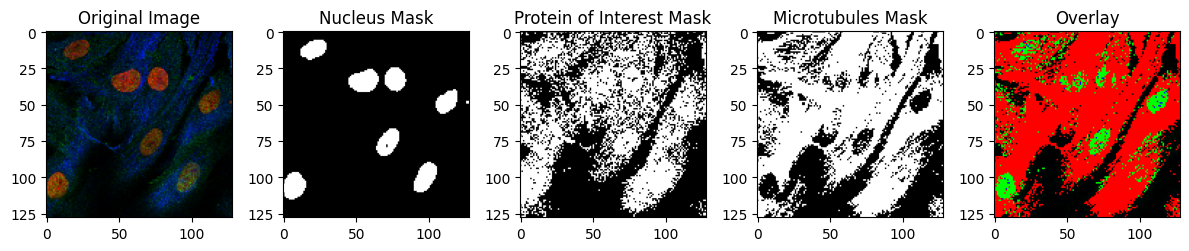

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'image' is your original image

# Threshold for nucleus (Blue Channel)
_, nucleus_mask = cv2.threshold(blue_channel, 20, 255, cv2.THRESH_BINARY)

# Threshold for protein of interest (Green Channel)
_, protein_mask = cv2.threshold(green_channel, 20, 255, cv2.THRESH_BINARY)

# Threshold for microtubules (Red Channel)
_, microtubules_mask = cv2.threshold(red_channel, 10, 255, cv2.THRESH_BINARY)

# Display the original image and the segmentation masks
plt.figure(figsize=(12, 4))

plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 5, 2)
plt.imshow(nucleus_mask, cmap='gray')
plt.title('Nucleus Mask')

plt.subplot(1, 5, 3)
plt.imshow(protein_mask, cmap='gray')
plt.title('Protein of Interest Mask')

plt.subplot(1, 5, 4)
plt.imshow(microtubules_mask, cmap='gray')
plt.title('Microtubules Mask')

# Overlay masks on the original image
overlay_image = image.copy()
overlay_image[nucleus_mask > 0] = [0, 0, 255]  # Blue for Nucleus
overlay_image[protein_mask > 0] = [0, 255, 0] # Green for Protein of Interest
overlay_image[microtubules_mask > 0] = [255, 0, 0]  # Red for Microtubules

plt.subplot(1, 5, 5)
plt.imshow(overlay_image)
plt.title('Overlay')

plt.tight_layout()
plt.show()

This segmentation approach could then be used as a custom preprocessing step.

In [ ]:
def custom_preprocessing(image):
    # Extract channels
    blue_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    red_channel = image[:, :, 2]

    # Thresholding or other segmentation techniques
    nucleus_mask = (blue_channel > 20).astype(int)
    protein_mask = (green_channel > 20).astype(int)
    microtubules_mask = (red_channel > 10).astype(int)

    # Directly overlay masks on the original image
    image[nucleus_mask > 0] = [0, 0, 255]  # Blue for Nucleus
    image[protein_mask > 0] = [0, 255, 0]  # Green for Protein of Interest
    image[microtubules_mask > 0] = [255, 0, 0]  # Red for Microtubules

    # Normalize image using ResNet_v2 preprocess_input
    image = preprocess_input(image)

    return image

However, despite these efforts, the incorporation of image segmentation did not yield an improvement in training or validation F1 score. Consequently, the exploration of this idea was not pursued further. It is worth considering the possibility that a more sophisticated approach, involving a machine learning model to derive optimal segmentation masks, could have proven beneficial. This information could then be integrated with the original image layers. Some examples online suggest using these segmentation masks for attention layers, allowing the model to focus on specific layers, such as the green layer containing the protein of interest. While this approach may lead to better results and are similar to an object-detection-oriented strategy, its complexity surpassed the scope of my current knowledge and was therefore not further explored.

## Training a simple CNN for 170 epoch

Before incorporating pretrained models, I conducted an exploration with several convolutional neural networks built from scratch. One notable method is visually presented below, providing valuable insights into the evolving probabilities across 170 epochs. This simple model consisted of only 1 convolutional layer, followed by 3 dense layers and used binary cross entropy as a loss function. A density plot was made after each epoch, encapsulating the model's learning journey, and the progression is encapsulated in a GIF.

The visual representation showcases the gradual separation of the two peaks of predictions across epochs for each class. This shows the model's learning process in effectively distinguishing between instances marked with true label 0 (green, indicating not part of the class) and true label 1 (yellow, indicating part of the class). It is intriguing to note that the more prevalent labels, such as class 4 and class 6, exhibit easily distinguishable peaks from the outset.

Additionally, the visual narrative extends to the width of the peaks. Peaks associated with true label 0 (green) are notably narrow after 170 epoch, centered around prediction 0.0, indicating the model's confidence in negative predictions. Conversely, the yellow peaks, representing true label 1, appear more spread out, underscoring the model's lower confidence in predicting instances of the positive class. This lack of confidence aligns with the observed low macro F1 score of 15%.

Despite providing valuable insights, this particular model was not further employed, as it achieved only an F1 score of approximately 15% on Kaggle.

In [ ]:
from IPython.display import Image, display
display(Image(url='https://i.ibb.co/jgJm2BD/epoch.gif'))

## On the use of different loss functions

Different loss functions were explored during the project, and a small note on 3 of them was written below.

In the pursuit of an effective loss function, the F1 loss stands out for capturing the delicate balance between precision and recall, a crucial consideration for imbalanced datasets. As this F1 score is also used in the evalution of the model, the ability to lower the loss function (where (1-F1) is decreased, resulting in increase in F1), this loss function seemed the most straightforward and easy to interpretete.

The Binary Crossentropy loss, a conventional choice, aligns with sigmoid activation and simplicity, making it robust for balanced datasets. However, it may grapple with imbalanced datasets due to an inherent class imbalance bias. Striking the right balance entails weighing the simplicity of conventional methods against the nuanced customization offered by advanced alternatives, emphasizing the need for thoughtful experimentation and evaluation.

The Binary Focal Crossentropy loss introduces adaptability, gracefully handling noisy data through parameters like alpha and gamma. The alpha parameter is a weighting factor assigned to each class. It addresses the issue of class imbalance (in true labels 0 and 1 for each class) by assigning higher weights to underrepresented classes (in this case true label 1), thereby giving them more importance during training. A higher alpha value for a specific class increases its contribution to the overall loss, ensuring that the model pays more attention to learning from examples of that class. The gamma parameter introduces a modulating factor that dynamically adjusts the focus on easy-to-classify and hard-to-classify examples. A higher gamma value results in a stronger down-weighting of well-classified instances (easy examples), directing the model's attention toward challenging examples. This adaptive mechanism helps the Focal Loss prioritize learning from instances that are initially misclassified or challenging, improving the model's performance on difficult cases. On top of that, it has a built in paramter to apply class balancing, which can be beneficial in a dataset that is very unbalanced like the one in this project.

In [ ]:
# Examples of loss functions used
model.compile(optimizer=adam_optimizer, loss=f1_loss,
              metrics=[tensorflow.keras.metrics.Recall(), tensorflow.keras.metrics.Precision()])
model.compile(optimizer=adam_optimizer, loss=tensorflow.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.75, gamma=2.0),
              metrics=[tensorflow.keras.metrics.Recall(), tensorflow.keras.metrics.Precision()])
model.compile(optimizer=adam_optimizer, loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tensorflow.keras.metrics.Recall(), tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.BinaryAccuracy()])

## Optimal Threshold Selection

During the initial phases, a ResNet50 model (loss=binary cross entropy, optimizer=Adam) encountered challenges in accurately identifying underrepresented classes using the default classification threshold of 0.5. Consequently, we are opting to establish custom thresholds for each class. Leveraging density plots proves instrumental in this process, as the objective is to pinpoint a threshold that maximizes the separation between the majority of instances with actual label 0 (green, indicating not belonging to the class) and those with actual label 1 (yellow, indicating belonging to the class).

Upon analysis, it is evident that applying a 0.5 threshold results in minimal predictions for most classes. Only classes 4 (Nucleoplasm) and 6 (Cytosol), characterized by abundance, exhibit reasonably satisfactory performance under this default threshold. However, careful examination of the density plots reveals two distinct peaks for most classes – one associated with lower probabilities (fortuitously corresponding to instances with label 0) and another linked to higher probabilities (fortuitously aligning with instances with label 1).

Even in cases where clear peaks are not apparent, a threshold exists that effectively separates the green and yellow regions. To optimize predictions, we are strategically selecting custom thresholds that minimize the overlapping area, ensuring accurate classification. These customized thresholds are visually presented on the density plots of predictions following the last 10 epochs, providing a clear representation of the chosen delineations.

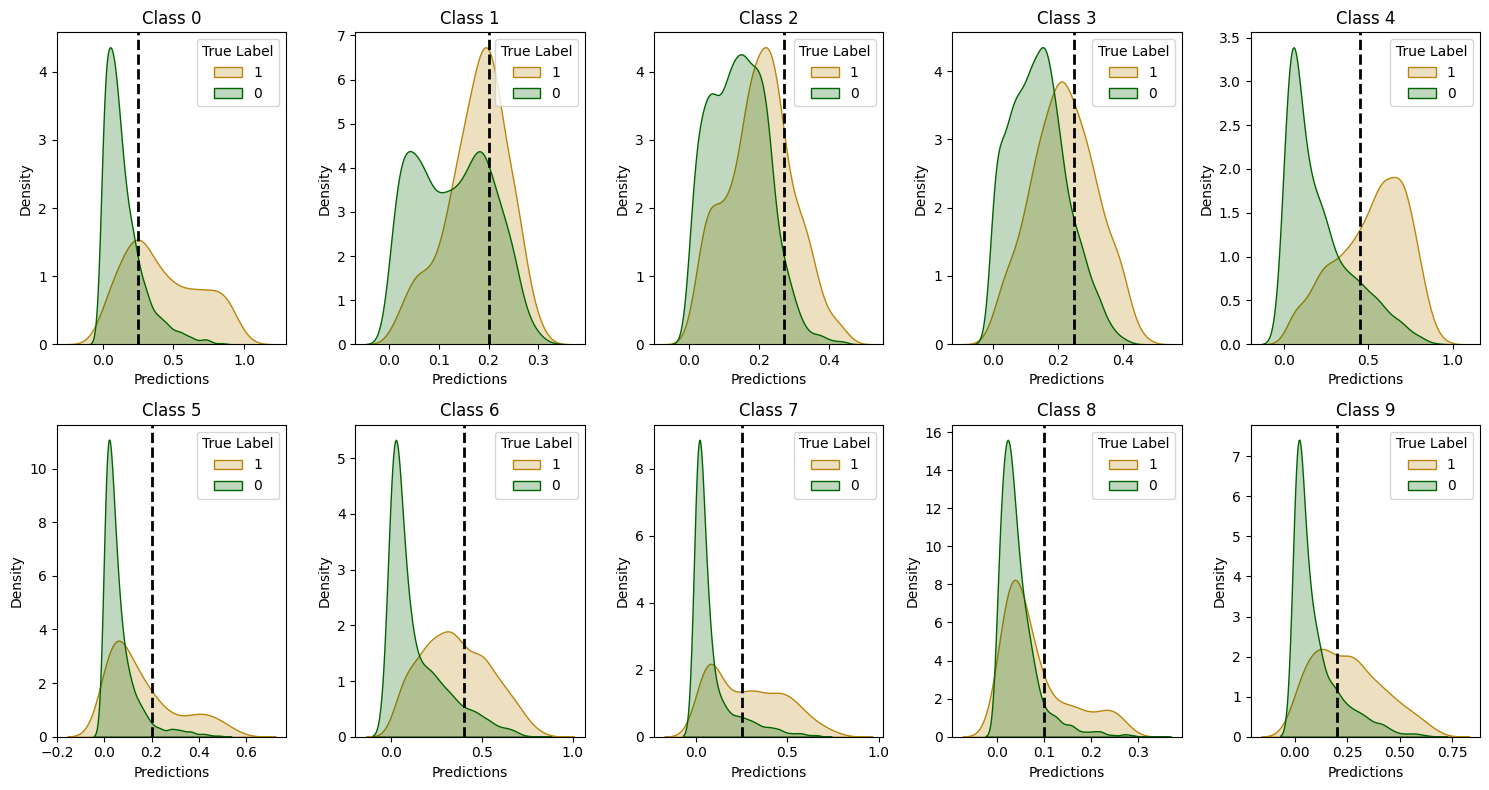

In [ ]:
# Define custom thresholds for each class
custom_thresholds = [0.25, 0.2, 0.27, 0.25, 0.45, 0.2, 0.4, 0.25, 0.1, 0.2]

# Plot density plots for each class
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.kdeplot(
        data=df[df['Class'] == i],
        x='Predictions',
        hue='True Labels',
        common_norm=False,
        fill=True,
        palette={0: 'darkgreen', 1: 'darkgoldenrod'}  # Specify line color
    )

    # Add vertical line for custom threshold
    plt.axvline(x=custom_thresholds[i], color='black', linestyle='--', linewidth=2, label='Custom Threshold')

    plt.title(f'Class {i}')
    plt.legend(title='True Label', labels=['1', '0'])

plt.tight_layout()
plt.show()


These custom thresholds are then used to make predictions again.

In [ ]:
# Apply custom thresholds to get binary predictions
predictions_custom_cutoff = (raw_predictions > np.array(custom_thresholds)).astype("int32")

# Get true labels
true_labels = val_df[list(new_column_names.values())].values

# Print classification report
print("Classification Report with custom thresholds for each class:")
print(classification_report(true_labels, predictions_custom_cutoff, target_names=list(new_column_names.values())))

Classification Report with custom thresholds for each class:
              precision    recall  f1-score   support

     class 0       0.32      0.69      0.44       321
     class 1       0.17      0.39      0.23       295
     class 2       0.39      0.21      0.27       433
     class 3       0.26      0.37      0.31       305
     class 4       0.81      0.65      0.72      1458
     class 5       0.23      0.30      0.26       171
     class 6       0.65      0.40      0.50       932
     class 7       0.46      0.52      0.49       439
     class 8       0.16      0.27      0.20       169
     class 9       0.19      0.57      0.29       198

   micro avg       0.43      0.49      0.46      4721
   macro avg       0.36      0.44      0.37      4721
weighted avg       0.53      0.49      0.48      4721
 samples avg       0.42      0.51      0.43      4721



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Opting for these customized thresholds resulted in a notable 13% improvement in the macro F1 score on the validation set. However, the corresponding boost on the public leaderboard on Kaggle was only 4%. This difference is likely attributable to a distinct distribution of labels in the test set as compared to the validation set.

To potentially refine this approach further, predictions on the validation dataset could have been conducted multiple times and subsequently averaged to derive the final predictions. This concept aligns with the Test Time Augmentation technique, similar to the methodology employed in generating predictions for the test set.